# Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive 
import os
import matplotlib.pyplot as plt

drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/MyDrive/explanations-for-computer-vision/")


Mounted at /content/gdrive


In [3]:
!pip install lime

# Object detector

In [4]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from lime.lime_image import LimeImageExplainer
from src.faster_rcnn import fasterrcnn_resnet18_fpn

from src.utils import jaccard

# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# our dataset has two classes only - background and person
num_classes = 2

In [5]:
# load an instance segmentation model pre-trained pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
model = fasterrcnn_resnet18_fpn(pretrained_backbone=True, num_classes=num_classes)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load model checkpoint
path = os.path.join(os.getcwd(), "./checkpoints/faster_rcnn_resnet1830_epochs.ckpt")
checkpoint = torch.load(path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device) 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

# PennFudan Dataset

In [6]:
import sys
sys.path.append("./detection")
from pennfudan_dataset import PennFudanDataset, get_transform

# use our dataset and defined transformations
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=False))
# changing to array


# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [7]:
# creating test image
num_image_test = 5
image_test = torch.utils.data.Subset(dataset_test, indices[:num_image_test])

# COCO Dataset

# Visualize the Detection



In [8]:
# pick one image from the test set
img, _ = image_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
from PIL import Image, ImageDraw

result = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
image = ImageDraw.Draw(result)  

for bbox in prediction[0]["boxes"]:
    image.rectangle(bbox.cpu().numpy().tolist(), outline ="red")

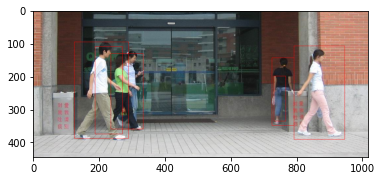

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(result)

# Explanations

## Import explainer

In [11]:
from src.sodexplainer import SODExplainer
explainer_sodex = SODExplainer(model=model)

## Lime Explanation

In [13]:
image_test = dataset_test[0][0]
image_test = image_test.permute(1,2,0).detach().numpy()
image_test= image_test.astype('double')

In [1]:
# probability_function = explainer_sodex.get_class_probability(dataset_test[0])
# probabilities = probability_function(np.array([image_test]))
# print(probabilities)

NameError: ignored

In [15]:
explanation = explainer_sodex.get_lime_explanation(image_test,dataset_test[0], num_samples=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Intercept 0.0021710168852149296
Prediction_local [0.0007399]
Right: tensor(0.0007, device='cuda:0')
Intercept 0.9978289831147852
Prediction_local [0.9992601]
Right: tensor(0.9993, device='cuda:0')


(-0.5, 558.5, 535.5, -0.5)

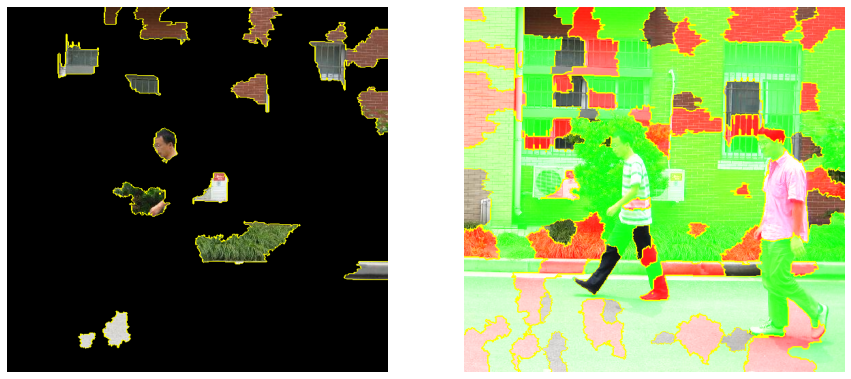

In [16]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=200, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

## Rise explanation

In [ ]:
image_test = dataset_test[0][0].permute(1,2,0)
# image_test = image_test.detach().numpy().astype('double')
sal, preds, masks = explainer_sodex.get_rise_explanation(image_test, N=6000, s=10, p1=0.5)
# sal, preds, masks = explainer_sodex.get_rise_explanation(torch.from_numpy(image_test), N=10, s=10, p1=0.5)

Generating masks: 100%|██████████| 6000/6000 [02:05<00:00, 47.70it/s]


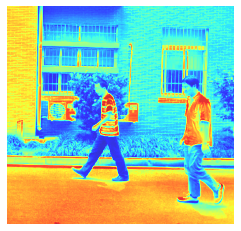

In [13]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(sal.cpu().numpy(), cmap='jet', alpha=0.8)
plt.show()

# Evaluation

In [ ]:
from src.eval import evaluate, get_maximum_point

## Pointing Game Accuracy

Run lime explanation on 5 images with num_samples=1000.

In [ ]:
explanations = []
for img in image_test:
  img_array = img[0].permute(1,2,0).detach().numpy().astype('double')
  explanation = explainer_sodex.get_lime_explanation(img_array,img, num_samples=1000)
  explanations.append(explanation)

RuntimeError: ignored

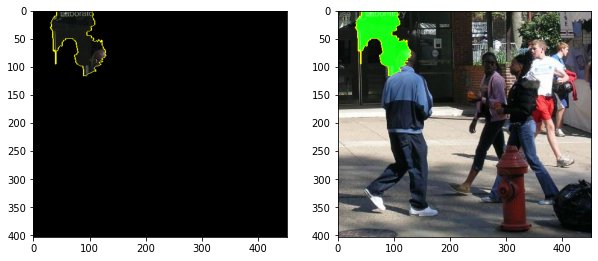

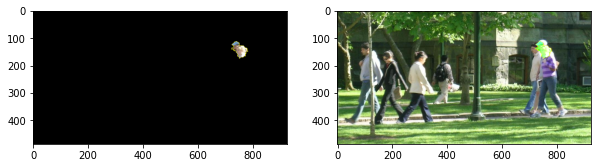

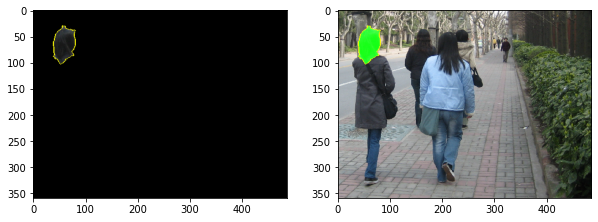

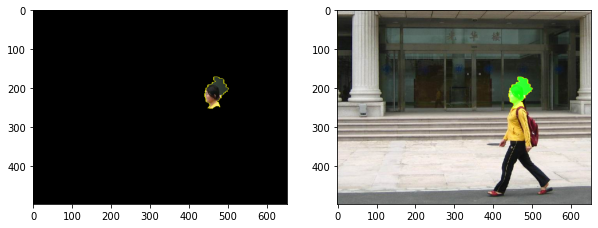

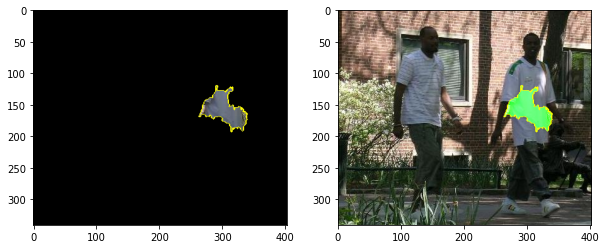

In [ ]:
from skimage.segmentation import mark_boundaries

for i in range(num_image_test):
  temp_1, mask_1 = explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=True, num_features=1, hide_rest=True) # <- consider only the most positive superpixel
  temp_2, mask_2 = explanations[i].get_image_and_mask(explanations[i].top_labels[0], positive_only=False, num_features=1, hide_rest=False)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
  ax1.imshow(mark_boundaries(temp_1, mask_1))
  ax2.imshow(mark_boundaries(temp_2, mask_2))
  # ax1.axis('off')
  # ax2.axis('off')

Run Rise explanation for 5 images with N=1000.

In [ ]:
sals = []
num_masks = 1000
for img in image_test:
  img = img[0].permute(1,2,0)
  sal, preds, masks = explainer_sodex.get_rise_explanation(img, N=num_masks, s=10, p1=0.5) 
  sals.append(sal)

Explaining: 100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]


Compute pointing game accuracy.

In [ ]:
evaluate(sals,image_test)

Visualize the results including detections, explanations, max. point of the saliency map (white circle).

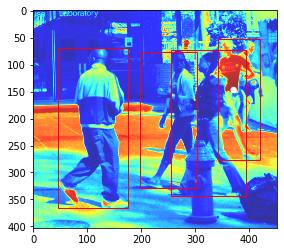

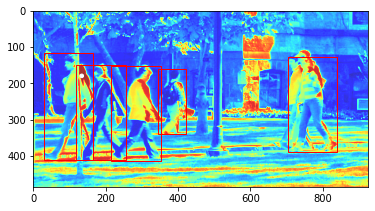

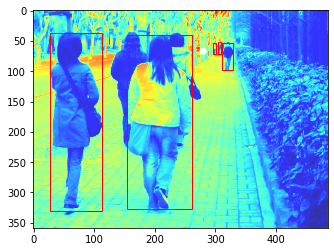

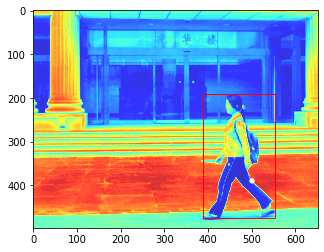

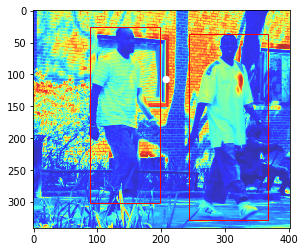

In [ ]:
from matplotlib.patches import Rectangle

for i, sal in enumerate(sals):
  # visualize saliency maps
  plt.imshow(sal.cpu().numpy(), cmap='jet', alpha=0.8)
  
  # visualize annotated bboxes
  for bbox in image_test[i][1]["boxes"]:
    width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    rect = Rectangle((bbox[0],bbox[1]),width,height,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
  
  # visualize the max.point
  y,x = get_maximum_point(sal)
  circle = plt.Circle((x, y), 5, color='w')
  plt.gca().add_patch(circle)
  plt.show()

# Insertion Deletion

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d
from torchvision import transforms
from torchvision.transforms import GaussianBlur

from src.utils import *
from src.eval import CausalMetric, auc, gkern

cudnn.benchmark = True

In [15]:
gaussian_blurr = GaussianBlur(int(2 * 12 - 1),12)

In [16]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)


# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

In [17]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=gaussian_blurr)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

In [18]:
image_test = image_test.permute(2,0,1)


In [19]:
image_test = torch.unsqueeze(image_test,0)


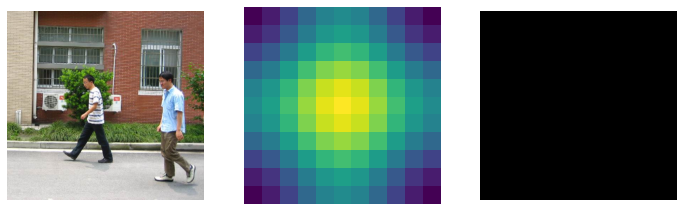

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
tensor_imshow(image_test[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(torch.zeros_like(image_test)[0])
plt.show()

In [21]:
hw = image_test.shape[2]*image_test.shape[3]

No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score above the threshold!
No score a

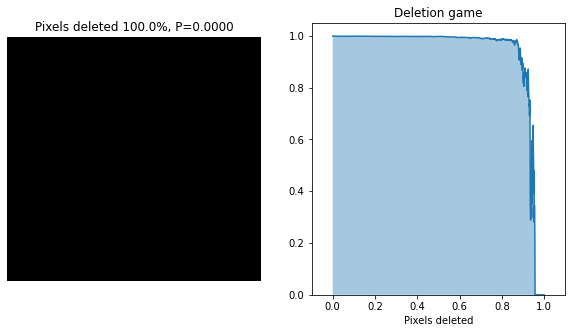

In [24]:
h = deletion.single_run(image_test,dataset_test[0], sal,hw, verbose=1)

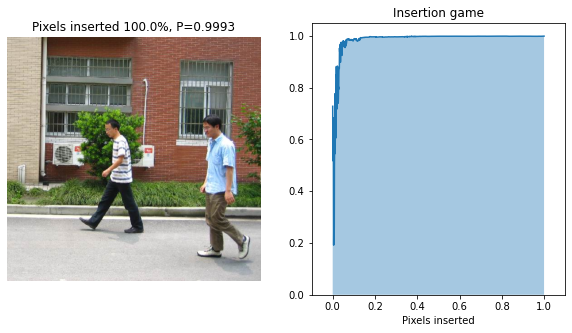

In [25]:
h = insertion.single_run(image_test,dataset_test[0],sal,hw, verbose=1)